## Phân cụm dữ liệu
- Tài liệu này sẽ thực hiện phân cụm dữ liệu để thể hiện đâu là phim có ảnh hưởng đến sở thích của người dùng nhất (có giá trị recommendation cao)
- Phương pháp thực hiện là sử dụng __PCA__ (Phân tích thành phần chính), dựa trên ma trận dữ liệu mà từng người dùng đã chấm cho từng phim
- Từ việc phân tích __PCA__ ta sẽ triển khai các thuật toán phân cụm liên quan

In [1]:
import pandas as pd
anime = pd.read_csv("Dataset/preprocessed_anime.csv")
rating = pd.read_csv("Dataset/rating.csv")
train_rating = pd.read_csv("Dataset/train_rating.csv")
test_rating = pd.read_csv("Dataset/test_rating.csv")

In [2]:
print(f"anime.shape={anime.shape}")
print(f"user.shape={rating.shape}")
print(f"train_rating.shape={train_rating.shape}")
print(f"test_rating.shape={test_rating.shape}")

anime.shape=(12017, 9)
user.shape=(7813737, 3)
train_rating.shape=(6260012, 4)
test_rating.shape=(1553725, 4)


In [3]:
anime.head(5)

,anime_id,name,genre,type,episodes,rating,members,n_genres,genre_primary
0,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.37,200630,4,drama
1,5114,Fullmetal Alchemist: Brotherhood,"Action,Adventure,Drama,Fantasy,Magic,Military,...",TV,64,9.26,793665,7,action
2,28977,Gintama°,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",TV,51,9.25,114262,7,action
3,9253,Steins;Gate,"Sci-Fi,Thriller",TV,24,9.17,673572,2,sci-fi
4,9969,Gintama&#039;,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",TV,51,9.16,151266,7,action


In [4]:
rating.head(5)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


- Ta tạo ma trận cho train và test
- Trước tiên cần merge với bảng anime để lấy tên phim

In [5]:
rating['confidence'] = rating['rating'].apply(lambda x: 5 if x == -1 else x)
train_rating['confidence'] = train_rating['rating'].apply(lambda x: 5 if x == -1 else x)
test_rating['confidence'] = test_rating['rating'].apply(lambda x: 5 if x == -1 else x)

In [6]:
from scipy.sparse import csr_matrix
import numpy as np


# Tạo danh sách đầy đủ user_id và item_id từ rating gốc
all_users = sorted(rating["user_id"].unique())
all_items = sorted(rating["anime_id"].unique())

# Hàng (row) i trong CSR global ↔ user gốc:
row_to_uid_global = np.array(all_users, dtype=int)     # shape = (n_users,)
# Cột (col) j trong CSR global ↔ item gốc:
col_to_iid_global = np.array(all_items, dtype=int)     # shape = (n_items,)

# Nếu cần ngược lại:
uid_to_row_global = {int(u): i for i, u in enumerate(row_to_uid_global)}
iid_to_col_global = {int(it): j for j, it in enumerate(col_to_iid_global)}


# Gán lại chỉ số index cho cả train và test
train_rating["user_idx"] = train_rating["user_id"].map(uid_to_row_global)
train_rating["item_idx"] = train_rating["anime_id"].map(iid_to_col_global)
test_rating["user_idx"]  = test_rating["user_id"].map(uid_to_row_global)
test_rating["item_idx"]  = test_rating["anime_id"].map(iid_to_col_global)


train_user_items = csr_matrix(
    (train_rating["confidence"].values, (train_rating["user_idx"].values, train_rating["item_idx"].values)),
    shape=(len(all_users), len(all_items)),
    dtype=np.float32
)

test_user_items = csr_matrix(
    (test_rating["confidence"].values, (test_rating["user_idx"].values, test_rating["item_idx"].values)),
    shape=(len(all_users), len(all_items)),
    dtype=np.float32
)


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(train_user_items)
pca_samples = pca.transform(train_user_items)

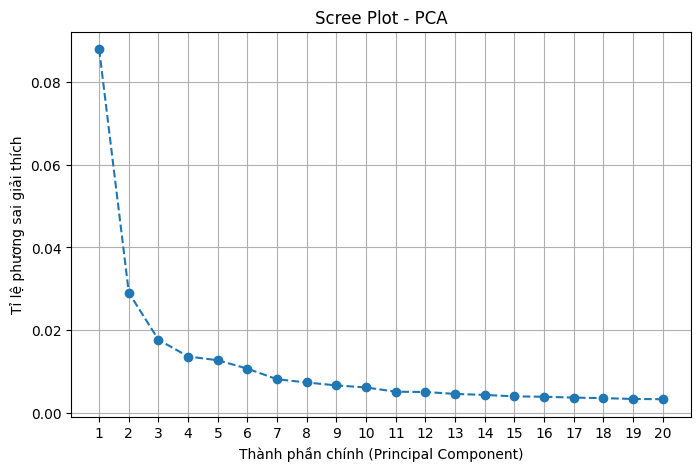

In [8]:
import matplotlib.pyplot as plt
explained_var = pca.explained_variance_ratio_

# Vẽ scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', linestyle='--')
plt.title("Scree Plot - PCA")
plt.xlabel("Thành phần chính (Principal Component)")
plt.ylabel("Tỉ lệ phương sai giải thích")
plt.xticks(range(1, len(explained_var)+1))
plt.grid(True)
plt.show()

- Scree Plot thể hiện 5 PC đầu chiếm hầu hết tỉ lệ giải thích phương sai của dữ liệu

In [9]:
ps = pd.DataFrame(pca_samples)
ps.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.605974,15.456898,-13.344124,6.648738,-3.029868,-3.055237,-1.079154,4.232987,9.304075,-0.038818,-4.476812,-0.585771,2.535030,-2.421723,-0.170385,2.552444,-4.826716,-3.655354,-2.439919,0.244009
1,-16.822969,3.315206,-2.866360,-2.991937,-0.119269,-3.234799,-1.436332,-3.050550,-1.752233,-0.854097,-0.823265,-1.098239,0.068637,0.024233,-0.654392,-0.063948,-0.030505,0.252635,-0.204071,-0.692778
2,3.212904,12.350559,14.875164,13.282875,-3.169316,-0.980496,3.168656,3.974797,0.477996,-0.673308,1.022544,-2.593785,-7.012674,-11.165643,5.672467,-2.900405,7.517482,-3.702081,4.720055,0.519243
3,-9.275928,3.764548,-2.450574,2.987323,-0.519292,0.791529,-1.115202,-2.114359,3.057209,-1.715199,1.409988,3.306059,-2.477505,-1.950209,0.753379,3.405684,3.751390,1.556633,0.429934,1.209571
4,25.120693,6.635279,2.283116,0.459038,-2.716263,-13.111191,10.968554,-3.084676,-12.667370,-19.170815,-0.963034,8.544920,1.068192,2.597804,-0.627363,-6.516212,5.292712,-5.412950,-5.594931,-8.614103


In [10]:
tocluster = pd.DataFrame(ps[[0, 1, 2]])
tocluster.head(5)

,0,1,2
0,4.605974,15.456898,-13.344124
1,-16.822969,3.315206,-2.866360
2,3.212904,12.350559,14.875164
3,-9.275928,3.764548,-2.450574
4,25.120693,6.635279,2.283116


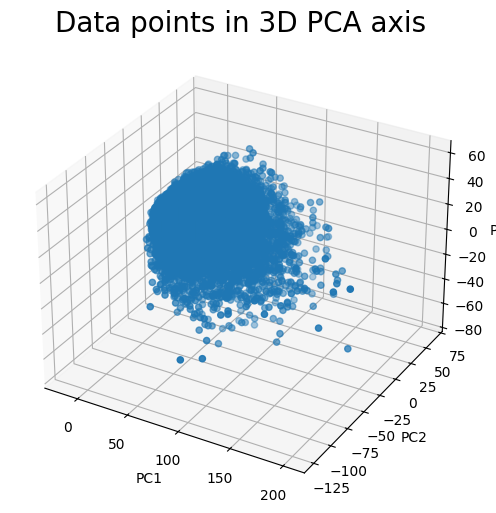

In [11]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (10, 6)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tocluster[0], tocluster[1], tocluster[2])  # trục x, y, z

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

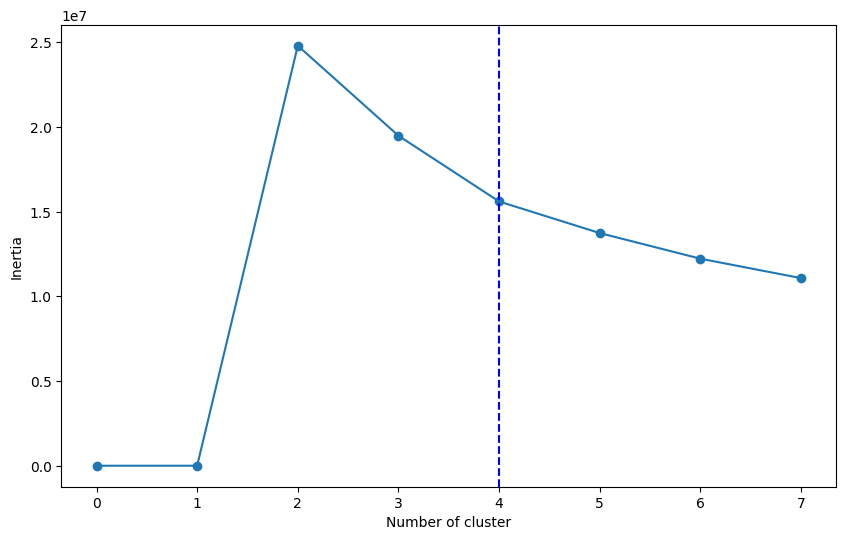

In [13]:
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

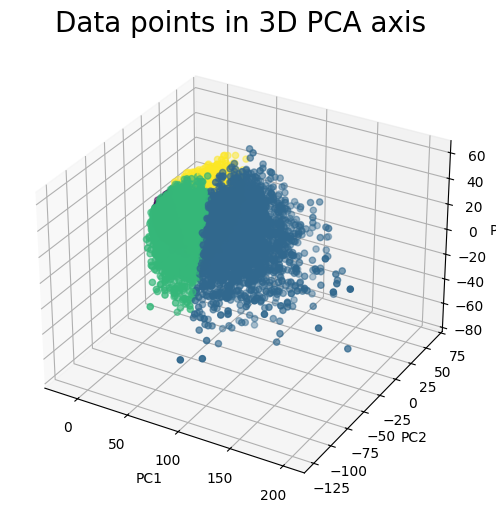

In [14]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=4, random_state=40).fit(tocluster)
c_preds = cluster.predict(tocluster)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tocluster[0], tocluster[1], tocluster[2], c = c_preds)  # trục x, y, z

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()


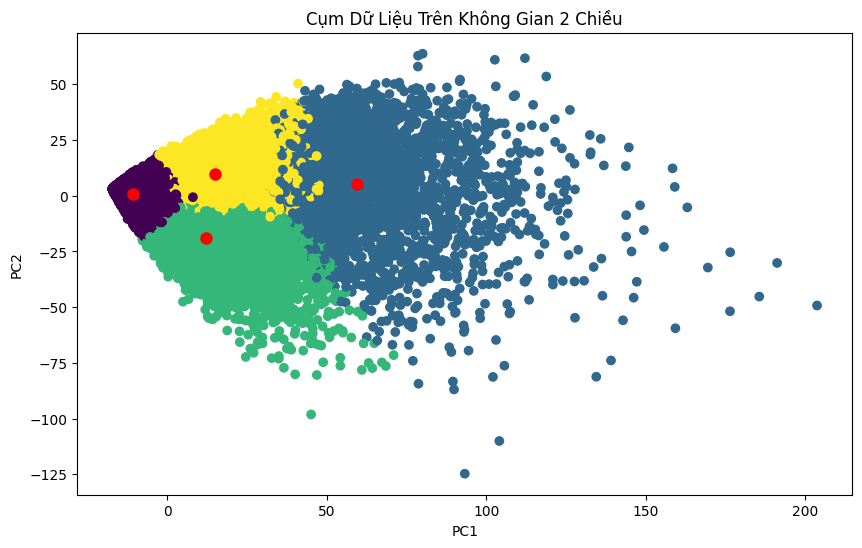

In [15]:
fig = plt.figure()
plt.scatter(tocluster[0], tocluster[1], c=c_preds)
for i, center in enumerate(cluster.cluster_centers_):
    plt.plot(center[0], center[1], 'o', markersize=8, alpha=1, color='red')

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.title("Cụm Dữ Liệu Trên Không Gian 2 Chiều")
plt.show()

In [16]:
from collections import defaultdict

K = 4  # số cụm

# từ dict rows_by_cluster ta có thể truy cập vào đúng danh sách rows của cluster cần tìm
rows_by_cluster = defaultdict(list)

for r, lab in enumerate(c_preds):
    if 0 <= lab < K:
        rows_by_cluster[int(lab)].append(r)

# Ép kiểu numpy và sort để index nhanh, ổn định
for k in range(K):
    rows = np.array(rows_by_cluster[k], dtype=np.int64)
    rows.sort()
    rows_by_cluster[k] = rows


In [17]:
cluster_csr = {}              # k -> csr_matrix (users_k x n_items)
localrow_to_globalrow = {}    # k -> np.ndarray (len=users_k), local_row -> global_row
globalrow_to_localrow = {}    # k -> dict (global_row -> local_row)
localrow_to_uid = {}          # k -> np.ndarray, local_row -> original user_id

for k in range(K):
    rows = rows_by_cluster[k]
    if rows.size == 0:
        continue

    csr_k = train_user_items[rows]             # giữ nguyên số cột (items)
    cluster_csr[k] = csr_k.tocsr()

    # Local row i trong csr_k ứng với global row = rows[i]
    localrow_to_globalrow[k] = rows.copy()
    globalrow_to_localrow[k] = {int(gr): int(i) for i, gr in enumerate(rows)}

    # Và uid gốc:
    localrow_to_uid[k] = row_to_uid_global[rows]

In [18]:
from implicit.nearest_neighbours import CosineRecommender

cluster_model = {}
for k in range(K):
    if k not in cluster_csr:
        continue
    model = CosineRecommender(K=100)  # chỉnh tuỳ ý
    model.fit(cluster_csr[k])
    cluster_model[k] = model

print("Đã train xong cụm:", list(cluster_model.keys()))

c:\Users\LU QUOC PHAP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\LU QUOC PHAP\AppData\Local\Programs\Python\Python312\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.012147188186645508 seconds
  warnings.warn(


ValueError: Buffer dtype mismatch, expected 'long' but got 'long long'

In [ ]:
def topN_popular(csr_mat, N=200):
    col_sum = np.asarray(csr_mat.sum(axis=0)).ravel()
    idx = np.argsort(-col_sum)[:N]   # chỉ số cột (global)
    return idx

cluster_top_items = {}
for k in cluster_csr:
    cluster_top_items[k] = topN_popular(cluster_csr[k], N=200)


In [ ]:
uids = list(all_users)  # ví dụ 500 user đầu
N = 10
predicted = {}

# Nếu cần build uid -> cluster:
uid_to_cluster = {}
for global_r, uid in enumerate(row_to_uid_global):
    lab = int(c_preds[global_r])
    if 0 <= lab < K:
        uid_to_cluster[int(uid)] = lab

# chuẩn bị top global fallback một lần
col_sum_global = np.asarray(train_user_items.sum(axis=0)).ravel()
top_global_cols = np.argsort(-col_sum_global)[:max(N, 200)]
top_global_items = [int(col_to_iid_global[j]) for j in top_global_cols[:N]]

for uid in uids:
    uid = int(uid)
    k = uid_to_cluster.get(uid, None)
    if (k is None) or (k not in cluster_model):
        predicted[uid] = top_global_items
        continue

    global_r = uid_to_row_global.get(uid, None)
    local_r = globalrow_to_localrow[k].get(global_r, None)
    if local_r is None:
        predicted[uid] = [int(col_to_iid_global[j]) for j in cluster_top_items[k][:N]]
        continue

    csr_k = cluster_csr[k]
    st, en = csr_k.indptr[local_r], csr_k.indptr[local_r+1]
    if en - st > 0:
        ids, scores = cluster_model[k].recommend(
            userid=local_r,
            user_items=csr_k[local_r],
            N=N,
            filter_already_liked_items=True
        )
        predicted[uid] = [int(col_to_iid_global[j]) for j in ids]
    else:
        predicted[uid] = [int(col_to_iid_global[j]) for j in cluster_top_items[k][:N]]

list(predicted.items())[:3]


[(1, [11617, 6547, 15809, 10620, 10793, 14813, 20507, 14741, 1535, 19163]),
 (2, [13469, 14741, 14227, 7791, 5680, 9989, 18153, 11887, 21647, 9617]),
 (3, [22319, 10620, 6547, 20, 22535, 1575, 9253, 2904, 4224, 10793])]

In [ ]:
ground_truth = (
    test_rating
    .groupby('user_idx')['item_idx']
    .apply(set)
    .to_dict()
)

In [ ]:
import metrics_eval
result = metrics_eval.evaluate_all(predicted=predicted, ground_truth=ground_truth, k=15)

In [ ]:
print(result)

{'Precision@15': 0.0024800750117205815, 'Recall@15': 0.0022274864158536687, 'MAP@15': 0.0010805576363739748}
